# Demo Notebook how to run models on static mouse datasets

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'iclr' #test
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [3]:
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian
from dataport.bcm.static import PreprocessedMouseData

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

<ipython-input-3-05b2d793f8c5>:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Iterable


Connecting konstantin@134.2.168.16:3306
Schema name: konstantin_nnsysident_iclr


---

In [ ]:
mei_direct_highest =       torch.load('mei_direct_highest')
mei_transfer_highest =     torch.load('mei_transfer_highest')
mei_direct_highestdiff =   torch.load('mei_direct_highestdiff')
mei_transfer_highestdiff = torch.load('mei_transfer_highestdiff')

In [ ]:
fontsize = 6

fig, axes = plt.subplots(2, 10, figsize=(10,1), dpi=450)
for i, ax in enumerate(axes.flatten()):
    ax.set_ylabel('bla')
    if i == 0:
        ax.set_ylabel('direct', fontsize=fontsize)
        ax.tick_params(
                        axis='both',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,
                        left=False,
                        right=False,
                        labelbottom=False) # labels along the bottom edge are off
        ax.set_yticklabels([])
    elif i == 10:
        ax.set_ylabel('transfer', fontsize=fontsize)
        ax.tick_params(
                        axis='both',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,
                        left=False,
                        right=False,
                        labelbottom=False) # labels along the bottom edge are off
        ax.set_yticklabels([])
    else:
        ax.axis("off")

    if i < 10:
        MEIs = mei_direct_highestdiff['MEIs']
        unit_IDs = mei_direct_highestdiff['unit_IDs']
    else:
        MEIs = mei_transfer_highestdiff['MEIs']
        unit_IDs = mei_transfer_highestdiff['unit_IDs']
        i = i-10
    
    ax.imshow(MEIs[i], cmap="gray", vmin=MEIs.min(), vmax=MEIs.max() ) 
    ax.text(0.5, 2.5, str(unit_IDs[i]), va='center', fontsize=4.5, color='k')
fig.savefig('mei.png')

In [6]:
# change path here
paths = ['data/static20457-5-9-preproc0.zip']

#paths = ['data/static22564-2-12-preproc0.zip']
dataset_fn = 'nnsysident.datasets.mouse_loaders.static_loaders'
dataset_config = dict(
    paths=paths,
    batch_size=10000,
    seed=1,
    file_tree=True,
    return_test_sampler=True,
    tier='test',
    #image_n=50,
    #image_base_seed=1,
    #multi_match_n=972,
    #multi_match_base_seed=1,
    #exclude_multi_match_n = 3625,

)

dataloaders = builder.get_data(dataset_fn, dataset_config)

data/static20457-5-9-preproc0 exists already. Not unpacking data/static20457-5-9-preproc0.zip
Returning only test sampler with repeats...


In [ ]:
images, responses = [], []
for x, y in dataloaders['test']['20457-5-9-0']:
    images.append(x.data.cpu().numpy())
    responses.append(y.data.cpu().numpy())

In [7]:
def get_SNR(responses):
    mu = np.array([np.mean(repeats, axis=0) for repeats in responses])
    mu_bar = np.mean(mu, axis=0)

    sigma_2 = np.array([np.var(repeats, ddof=1, axis=0) for repeats in responses])
    sigma_2_bar = np.mean(sigma_2, axis=0)

    SNR = (1/mu.shape[0] * np.sum((mu - mu_bar)**2, axis=0)) / sigma_2_bar
    return SNR, sigma_2

images, responses = [], []
for x, y in dataloaders['test']['20457-5-9-0']:
    images.append(x.data.cpu().numpy())
    responses.append(y.data.cpu().numpy())

SNR, sigma_2 = get_SNR(responses)
print('SNR = {}'.format(SNR))

SNR = [0.125401   0.4528086  0.29499984 ... 0.40001678 0.49493545 0.5992377 ]


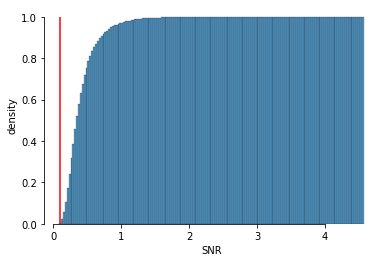

In [23]:
ax = sns.histplot(SNR, cumulative=True, stat='density')
ax.set(xlabel='SNR', ylabel='density')
plt.vlines(0.1, 0, 1, color='r')
sns.despine(trim=True)
#ax.figure.savefig('SNR.png')

In [22]:
ax.f

In [ ]:

responses_ansc = []
for repeats in responses:
    repeats_ansc = ansc(repeats)
    responses_ansc.append(repeats_ansc)
    
    
def ansc(x):
    return 2* np.sqrt(x + 3/8)

SNR_ansc, sigma_2_ansc = get_SNR(responses_ansc)
print('SNR_ansc = {}'.format(SNR_ansc))

In [ ]:
{'model_hash': 'c0c10c6d196e53d919b3e0bb13b154c7',
 'dataset_hash': '770806cc79fdc0e8e1a1eab0fa7dfcd1',
 'trainer_hash': '3c6008284286683e7ce19e9e1269f507',
 'seed': 4}

# Get Model

### The New gaussian readout: change gauss_type for the different modes

In [ ]:
model_fn = 'nnsysident.models.models.se2d_fullgaussian2d'

model_config = {'init_mu_range': 0.55,
                 'init_sigma': 0.4,
                 'input_kern': 15,
                 'hidden_kern': 13,
                 'gamma_input': 1.0,
                 'grid_mean_predictor': None,
                 'gamma_readout': 2.439,
                 'share_features': False,
                 'share_transform': False}


model = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)

# Get Trainer

In [ ]:
trainer_fn = 'nnsysident.training.trainers.standard_trainer'
trainer_config = dict(track_training=True) #detach_core=True, 
trainer = builder.get_trainer(trainer_fn, trainer_config)

# Run Training

In [ ]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1)

In [ ]:
np.unique(dataloaders['train']['24391-19-14-0'].dataset.neurons.layer)

In [ ]:
grid = model.readout['24391-19-14-0'].grid.squeeze().cpu().data.numpy()

In [ ]:
grid

In [ ]:
plt.scatter(*grid.T)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig('zhiwei_mus.png')

In [ ]:
features = model.readout['24391-19-14-0'].features.cpu().data.numpy().squeeze()

In [ ]:
plt.hist(features.flatten(), bins=50)
plt.savefig('zhiwei_features.png')

In [ ]:
torch.save(grid, 'zhiwei_mus')

In [ ]:
grid.T.shape

In [ ]:
grid.shape